In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Lambda, LeakyReLU, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.backend import random_normal

import matplotlib.pyplot as plt
from PIL import Image
import random

In [ ]:
#loading MNIST data
(x_train, y_train), (x_test, y_test)  = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
# x_val, y_val = x_test[:9000], y_test[:9000]
# x_test, y_test = x_test[9000:], y_test[9000:]

In [ ]:
x_train = x_train.reshape([60000,784])
# x_val = x_val.reshape([9000, 784])
x_test = x_test.reshape([10000, 784])

x_train = x_train.astype('float32')
# x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train/255.
# x_val = x_val/255.
x_test = x_test/255.

In [ ]:
# dimension of multivariate normal
code_size = 15

In [ ]:
# sampling layer
class Sampler(Layer):

  def call(self, inputs):
    mean_, log_var_ = inputs
    batch = tf.shape(mean_)[0]
    dim = tf.shape(mean_)[1]
    eps = random_normal(shape=(batch, dim))
    return mean_ + tf.exp(0.5 * log_var_)* eps

In [ ]:
input_img = Input(shape=(784,))
#encoder
encoded = Dense(300, activation='relu')(input_img)
encoded = Dense(200, activation='relu')(encoded)
encoded = Dense(100, activation='sigmoid')(encoded)
mean_ = Dense(code_size, name='latent_mean')(encoded)
log_var_ = Dense(code_size, name='latent_std_dev')(encoded)
z = Sampler()([mean_, log_var_])
encoder = Model(input_img, [mean_, log_var_, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 300)          235500      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 200)          60200       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 100)          20100       ['dense_1[0][0]']                
                                                                                            

In [ ]:
decoder_input = Input(shape=(code_size, ), name='decoder_input')
decoded = Dense(100, activation='relu')(decoder_input)
decoded = Dense(200, activation='relu')(decoded)
decoded = Dense(300, activation='relu')(decoded)
x = Dense(784, activation = 'sigmoid')(decoded)
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 15)]              0         
                                                                 
 dense_3 (Dense)             (None, 100)               1600      
                                                                 
 dense_4 (Dense)             (None, 200)               20200     
                                                                 
 dense_5 (Dense)             (None, 300)               60300     
                                                                 
 dense_6 (Dense)             (None, 784)               235984    
                                                                 
Total params: 318,084
Trainable params: 318,084
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class VAE(Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss = Mean(name='total_loss')
    self.recon_loss = Mean(name='reconstruction_loss')
    self.kl_div_loss = Mean(name='kl_loss')

  @property
  def metrics(self):
    return [
        self.total_loss,
        self.recon_loss,
        self.kl_div_loss,
    ]

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder(data)
      reconstruction = self.decoder(z)
      reconstruction_loss = tf.reduce_mean(
          tf.reduce_sum(
            binary_crossentropy(data, reconstruction)
          )
      )
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
      total_loss = reconstruction_loss + kl_loss
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      self.total_loss.update_state(total_loss)
      self.recon_loss.update_state(reconstruction_loss)
      self.kl_div_loss.update_state(kl_loss)
      return {
          "loss": self.total_loss.result(),
          "reconstruction_loss": self.recon_loss.result(),
          "kl_loss": self.kl_div_loss.result(),
      }

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam())
vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 8s 8ms/step - loss: 39.0245 - reconstruction_loss: 33.0448 - kl_loss: 0.9555
Epoch 2/30
469/469 [==============================] - 4s 8ms/step - loss: 30.7528 - reconstruction_loss: 27.9552 - kl_loss: 2.3762
Epoch 3/30
469/469 [==============================] - 3s 7ms/step - loss: 29.2864 - reconstruction_loss: 25.6074 - kl_loss: 3.4038
Epoch 4/30
469/469 [==============================] - 2s 5ms/step - loss: 28.2712 - reconstruction_loss: 24.0284 - kl_loss: 4.0644
Epoch 5/30
469/469 [==============================] - 2s 5ms/step - loss: 27.6925 - reconstruction_loss: 23.2790 - kl_loss: 4.4024
Epoch 6/30
469/469 [==============================] - 2s 4ms/step - loss: 27.4558 - reconstruction_loss: 22.8365 - kl_loss: 4.5725
Epoch 7/30
469/469 [==============================] - 2s 4ms/step - loss: 27.2713 - reconstruction_loss: 22.5321 - kl_loss: 4.7261
Epoch 8/30
469/469 [==============================] - 2s 4ms/step - loss: 27.1339 -

1875/1875 [==============================] - 3s 2ms/step


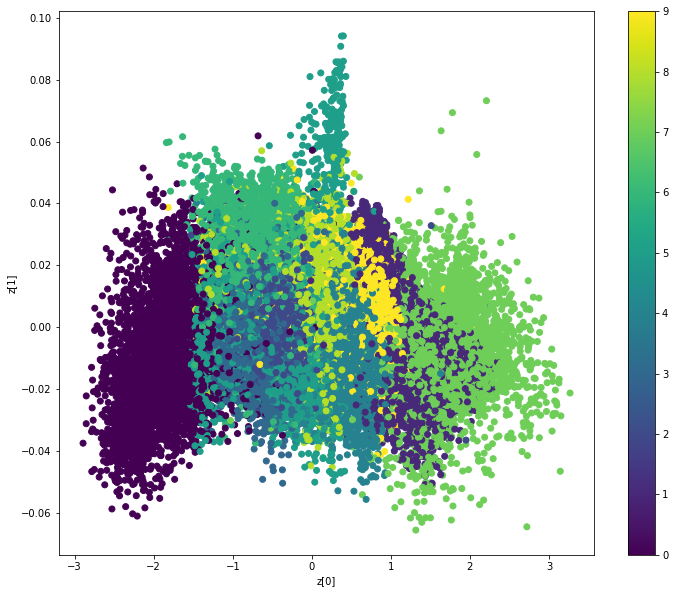

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


plot_label_clusters(vae, x_train, y_train)

In [ ]:
def interpolates(x_test, y):
  pass